In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

### Homework 1(a)

**Problem 1:** Implement solver for Kepler's equation using Newton's method

In [2]:
def g(E, e, M):
    """
    Return error on solution to Kepler's equation
    """
    return E - e*np.sin(E) - M


def E_sol(e, M, error=2e-16, max_iter=1e3):
    """
    Solve for E using Newton's method
    """
    # initial guess
    E = M + .85*e*np.sign(np.sin(M))

    i = 0
    # iterate until the specified precision is reached up to limited # of iterations
    while (abs(g(E, e, M)).any() > error) & (i < max_iter):
        E -= g(E, e, M)/(1 - e*np.cos(E))
        i += 1

    return E

**Problem 2:** Test it to check it works on 0 < e < 1 and 0 < M < 2π

max error:	 0.0
max error:	 4.440892098500626e-16
max error:	 8.881784197001252e-16
max error:	 8.881784197001252e-16
max error:	 8.881784197001252e-16


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


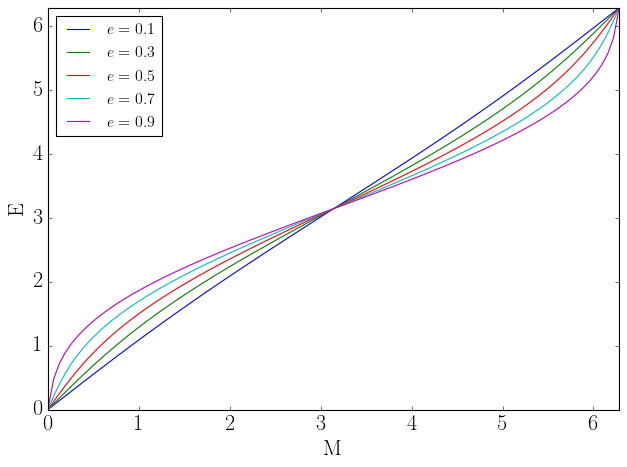

In [3]:
M = np.linspace(0, 2*math.pi, 100)

for e in np.arange(0.1, 1, .2):
    E = E_sol(e, M)
    plt.plot(M, E, label=r'$e=%s$'%(round(e,1)))
    print('max error:\t', max(g(E, e, M)))
plt.legend(loc='upper left')
plt.xlim(M.min(), M.max())
plt.ylim(M.min(), M.max())
plt.xlabel('M', fontsize=20)
plt.ylabel('E', fontsize=20)
plt.tight_layout()
plt.show()

### Homework 1(b)

**Problem 1:** Write a function to implement the radial velocity/Doppler formula for 
a planet on an elliptical orbit (you will need to call your Kepler equation
solver)

In [4]:
def rv(t, K, P, tp, e, pomega, gamma):
    """
    Radial velocity model of the star

    K 		: rv amplitude (km/s)
    P 		: peroid (days)
    tp 		: time of periastron (days)
    e 		: eccentricity
    pomega 	: pericenter angle (rad)
    gamma 	: velocity of center of mass
    """
    # K = (2*math.pi*G)/(P*(1-e**2)**(3/2))**(1/3) * Mp*np.sin(i)/(Ms + Mp)**(2/3)

    M = 2*math.pi/P * (t - tp)
    E = E_sol(e, M)

    f = 2*np.arctan(((1+e)/(1-e))**.5 * np.tan(E/2))

    vz = K*np.cos(f)*np.cos(pomega) - K*np.sin(f)*np.sin(pomega) + gamma + K*e*np.cos(pomega)

    return vz

Let's check that the model outputs a sensible looking rv curve:

In [5]:
K, P, tp, e, pomega, gamma =  1, 2, .25, .9, 2, 10
t = np.linspace(0,5,10e3)

vz = rv(t, K, P, tp, e, pomega, gamma)

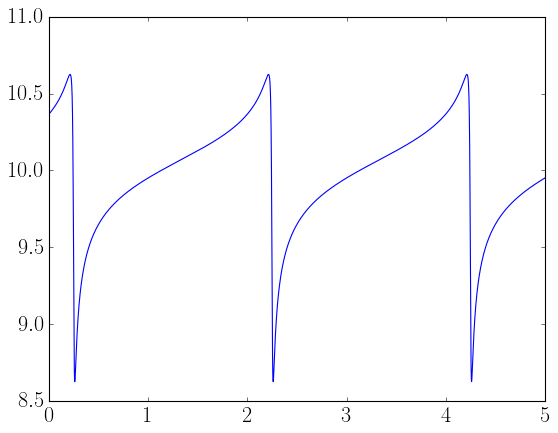

In [6]:
plt.plot(t, vz);

**Problem 2:** Find the period of the planet in the RV dataset contained in
mystery_planet01.txt [columns are: time, RV (m/s), error (m/s)]. Plot
your periodogram.

Read in and plot data:

In [7]:
data = pd.read_csv('files/mystery_planet01.txt', delim_whitespace=True, header=None)

time, rv_val, rv_err = np.array(data[0]), np.array(data[1]), np.array(data[2])
time -= time[0]

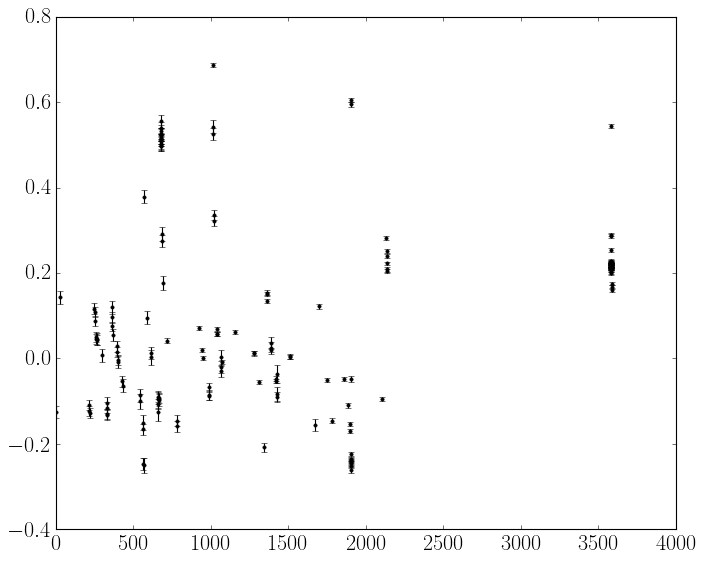

In [8]:
plt.figure(figsize=[10,8])
plt.errorbar(time, rv_val, yerr=rv_err, fmt='.', color='k')
plt.ticklabel_format(useOffset=False)
plt.show()

Periodogram implementation: test $10^5$ trial periods ranging .1-200 days. For each period, sort RV points
by phase, and take sum of squares of differences of
successive points

In [9]:
def phase_fold(time, rv_val, rv_err, P):
    
    fold = time % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_rv_val = rv_val[phase_sort]
    phase_rv_err = rv_err[phase_sort]
    
    return phase_time, phase_rv_val, phase_rv_err

best period: 111.46740267402673


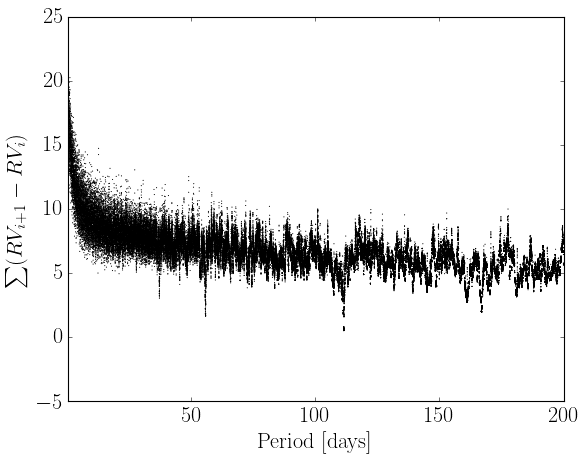

In [10]:
pgrid = np.linspace(.1,200,1e5)
err_sum = []

for period in pgrid:
    phase_time, phase_rv_val, phase_rv_err = phase_fold(time, rv_val, rv_err, period)   
    err_sum.append(np.sum((np.diff(phase_rv_val))**2))

print('best period:', pgrid[np.argmin(err_sum)])
plt.scatter(pgrid, err_sum, edgecolor='none', facecolor='k', s=1)
plt.xlabel('Period [days]', fontsize=20)
plt.ylabel(r'$\sum (RV_{i+1}-RV_i)$', fontsize=20)
plt.xlim(pgrid[0], pgrid[-1])
plt.show()

**Problem 3:** Use this to fit RV data, adjusting the parameters to improve your fit.
What P, e, tp , γ, and K do you find?

In [11]:
def plot_rv_model(K, P, tp, e, pomega, gamma, phase_time, phase_rv_val, phase_rv_err):
    
    t = np.linspace(0,P,10e3)
    vz = rv(t, K, P, tp, e, pomega, gamma)
    
    model_rv = rv(phase_time, K, P, tp, e, pomega, gamma)
    chi_val = np.sum(((phase_rv_val - model_rv)/phase_rv_err)**2)
    
    lbl = r'$K=%.3f, P=%.3f, t_p=%.3f, e=%.3f, \varpi=%.3f, \gamma=%.3f$'%(K, P, tp, e, pomega, gamma)

    plt.figure(figsize=[10,8])
    plt.errorbar(phase_time, phase_rv_val, yerr=phase_rv_err, fmt='.', color='k')
    plt.plot(t, vz, color='r', label=r'$\chi^2=%.3f$'%(chi_val))
    plt.text(P-2, .72, lbl, ha='right', fontsize=18)
    plt.xlim(0,P)
    plt.xlabel('Phase [days]', fontsize=20)
    plt.ylabel(r'rv [km s$^{-1}$]', fontsize=20)
    plt.ticklabel_format(useOffset=False)
    plt.legend(loc='lower right')
    plt.title('RV Model Fit', fontsize=22)
    plt.minorticks_on()
    plt.show()

Before we optimize a fit for the model, let's first choose an initial set of parameters that look close to the data:

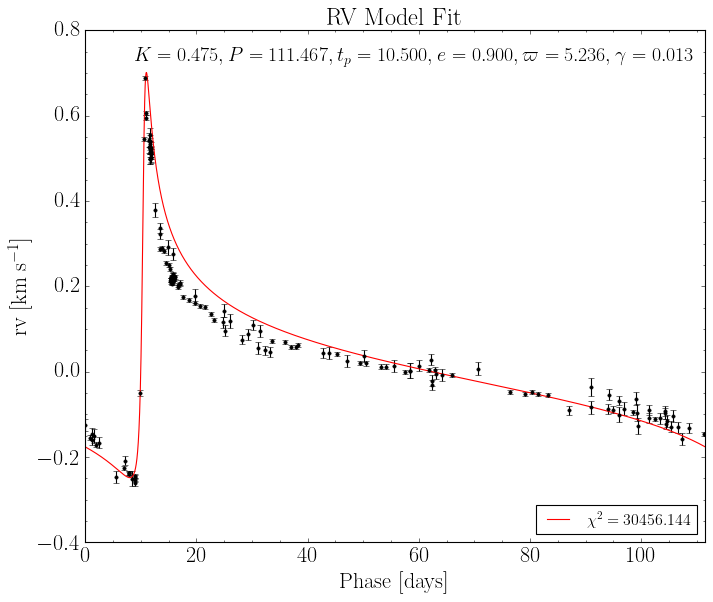

In [12]:
K = (max(rv_val)-min(rv_val))/2
P = pgrid[np.argmin(err_sum)]
tp = 10.5
e = .9
pomega = 300 * math.pi/180
gamma = np.median(rv_val) - .1

phase_time, phase_rv_val, phase_rv_err = phase_fold(time, rv_val, rv_err, P)

plot_rv_model(K, P, tp, e, pomega, gamma, phase_time, phase_rv_val, phase_rv_err)

Assume that the rv we observe (for each observation $i=\{1,...,N\}$ deviate from an underlying model (given by set parameters $\theta$) by a Gaussian distributed error, i.e. if $m(\theta)_i$ is the model prediction for time $t_i$, the probability of observing $rv_i$ given $t_i, \sigma_{rv,i}$ and $\theta$ is:

$p(rv_i|t_i, \sigma_{rv,i}, \theta) =  \frac{1}{2\pi\sigma_{rv,i}} \mathrm{exp}\left(-\frac{rv_i - m(\theta)_i}{2\sigma_{rv,i}} \right)$

such that the likelihood of over all data points is the product of conditional probabilities:

$\mathcal{L} = \displaystyle\prod_{i=1}^N p(rv_i|t_i, \sigma_{rv,i}, \theta)$

which can be more simply evaluated as a summation by taking the log:

$\log\mathcal{L} \propto -\displaystyle\sum_{i=1}^N \frac{rv_i - m(\theta)_i}{2\sigma_{rv,i}} = -\frac{1}{2}\chi^2$

In [13]:
def log_likelihood(theta, data, P):
    """
    Assume Gaussian likelihood function
    theta : model parameters (K, tp, e, pomega, gamma)
    data  : phase-folded time, rv_val, rv_err
    P     : period, fixed during optimization
    """
    K, tp, e, pomega, gamma = theta
    phase_time, phase_rv_val, phase_rv_err = data
    
    phase_rv_model = rv(phase_time, K, P, tp, e, pomega, gamma)
    
    return -0.5 * np.sum((phase_rv_val - phase_rv_model)**2/phase_rv_err**2)

nll = lambda *args: -log_likelihood(*args)

Now we want to estimate the maximum likelihood solution for our model. To do this we will minimize the negative log likelihood ($\frac{1}{2} \chi^2$).
Note: bounds are added to the optimizer to prevent unphysical solutions (e.g. $e<0$), and to fix the problem of underfitting data points (e.g. letting $K<(RV_{max}-RV_{min})/2$).

In [14]:
initial = [K, tp, e, pomega, gamma]
bounds  = [(K,K+1), (0,20), (0,1), (0,2*math.pi), (-1,1)]
data    = phase_time, phase_rv_val, phase_rv_err

soln = minimize(nll, initial, method='TNC', bounds=bounds, args=(data, P))

In [15]:
print(soln)
print('initial:', initial)

     fun: 882.5466248516966
     jac: array([ 1.05670189e+04, -7.41938493e+00, -1.75543846e+00,  2.81200982e+00,
       -8.29345481e-02])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 23
  status: 3
 success: False
       x: array([ 4.74800000e-01,  1.06246731e+01,  9.38057173e-01,  5.25478751e+00,
       -8.35416399e-03])
initial: [0.47480000000000006, 10.5, 0.9, 5.235987755982989, 0.012500000000000039]


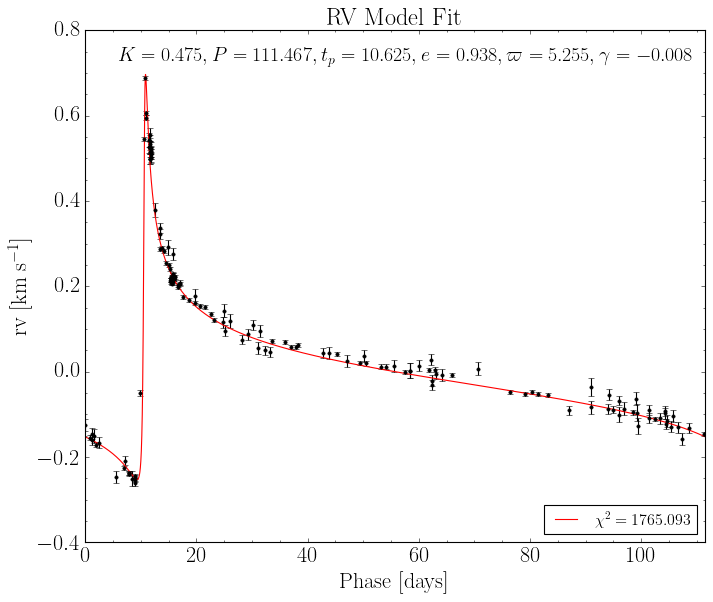

In [16]:
K_sol, tp_sol, e_sol, pomega_sol, gamma_sol = soln.x
plot_rv_model(K_sol, P, tp_sol, e_sol, pomega_sol, gamma_sol, phase_time, phase_rv_val, phase_rv_err)

We see that the optimizer has found a soultion with a better fit ($\chi^2=1765$) than our initial guess ($\chi^2=30,456$).

These values are in good agreement with literature for HD 80606b! 
![](files/lit_values.png)
(source: NASA exoplanet archive https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=HD+80606+b&type=CONFIRMED_PLANET)